# DGA Detection using Machine Learning

This Jupyter Notebook contains code that performs the following:

1. Feature Engineering
2. Model Building
3. Model Evaluation
4. Hyperparameter Search

In [33]:
import math
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from google.colab import files
uploaded = files.upload()

Saving dga_data_full.csv to dga_data_full (1).csv
Saving umbrella-top-1m.csv to umbrella-top-1m (1).csv


In [34]:
df = pd.read_csv("dga_data_full.csv")
print(df)

        isDGA                      domain                            host  \
0         dga  6xzxsw3sokvg1tc752y1a6p0af  6xzxsw3sokvg1tc752y1a6p0af.com   
1         dga              glbtlxwwhbnpxs               glbtlxwwhbnpxs.ru   
2         dga              xxmamopyipbfpk               xxmamopyipbfpk.ru   
3         dga   zfd5szpi18i85wj9uy13l69rg   zfd5szpi18i85wj9uy13l69rg.net   
4         dga                jpqftymiuver                 jpqftymiuver.ru   
...       ...                         ...                             ...   
159995  legit                     manhunt                     manhunt.net   
159996  legit                      yupptv                      yupptv.com   
159997  legit                    bbcmundo                    bbcmundo.com   
159998  legit                   kanogames                   kanogames.com   
159999  legit                   roadrover                    roadrover.cn   

            subclass  
0        gameoverdga  
1       cryptolocker  
2     

In [35]:
df = df.drop(columns=["domain", "subclass"])
df = df.rename(columns={"host": "domain"})
df["domain"] = df["domain"].str.replace(r"\s+", "", regex=True)
df["isDGA"] = (df["isDGA"] == "dga").astype(int)
print(df)

        isDGA                          domain
0           1  6xzxsw3sokvg1tc752y1a6p0af.com
1           1               glbtlxwwhbnpxs.ru
2           1               xxmamopyipbfpk.ru
3           1   zfd5szpi18i85wj9uy13l69rg.net
4           1                 jpqftymiuver.ru
...       ...                             ...
159995      0                     manhunt.net
159996      0                      yupptv.com
159997      0                    bbcmundo.com
159998      0                   kanogames.com
159999      0                    roadrover.cn

[160000 rows x 2 columns]


# Basic Examination of Data

Firstly, let's examine the data to ensure that the data we are working with is not skewed. As much as possible, there should be an equal number of DGA and non-DGA domains

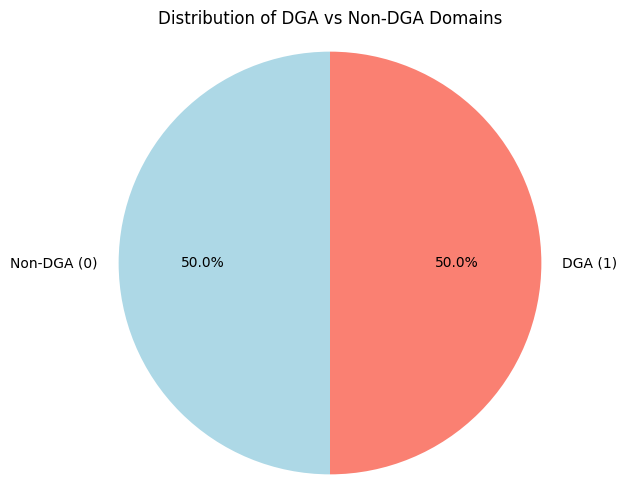

In [36]:
counts = df["isDGA"].value_counts()
labels = ["Non-DGA (0)", "DGA (1)"]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=["lightblue", "salmon"])
plt.title("Distribution of DGA vs Non-DGA Domains")
plt.axis("equal")
plt.show()

# Feature Engineering

After performing some research, I found that these features are commonly used and recommended for DGA detection:

1. Domain Length
2. Shannon Entropy
3. Digits Ratio
4. Vowel to Consonant Ratio
5. Digit to Letter Ratio
6. N-Gram Score
7. Tokenising
8. Max Consecutive Consonants
9. Number of Unique Characters

Therefore, the following sections will explore each feature by plotting graphs of DGA vs non-DGA to determine how well each feature can separate our data and if they should be included as a feature in training the model.

## Domain Length

Non-DGA domains often have moderate and relatively consistent length while DGA domains can exhibit more extreme length variation.

        isDGA                          domain  domain_length
0           1  6xzxsw3sokvg1tc752y1a6p0af.com             30
1           1               glbtlxwwhbnpxs.ru             17
2           1               xxmamopyipbfpk.ru             17
3           1   zfd5szpi18i85wj9uy13l69rg.net             29
4           1                 jpqftymiuver.ru             15
...       ...                             ...            ...
159995      0                     manhunt.net             11
159996      0                      yupptv.com             10
159997      0                    bbcmundo.com             12
159998      0                   kanogames.com             13
159999      0                    roadrover.cn             12

[160000 rows x 3 columns]


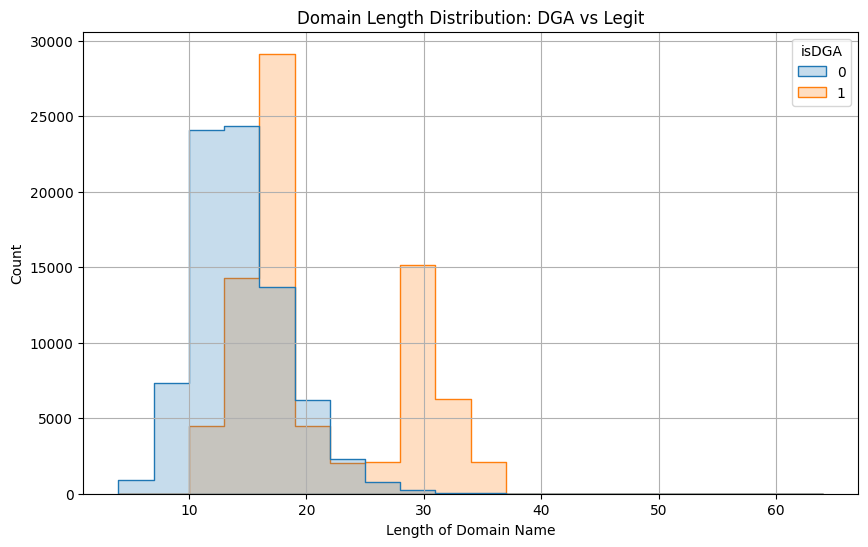

In [37]:
df["domain_length"] = df["domain"].str.len()
print(df)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="domain_length", hue="isDGA", bins=20, element="step", stat="count", common_norm=False)
plt.title("Domain Length Distribution: DGA vs Legit")
plt.xlabel("Length of Domain Name")
plt.ylabel("Count")
plt.grid(True)
plt.show()

### Verdict

As seen, the plots between the domain lengths of non-DGA and DGA are clearly separated. This indicates that domain length would be a good feature to predict whether a domain is DGA or non-DGA.

## Shannon Entropy

Shannon entropy is a way to quantify the randomness / uncertainty of a domain. For example, Google.com may be less random compared to xyz123.com. Since non-DGA domains are generally selected for human readability, they should have a lower shannon entropy compared to randomly generated domain names.

The formula for shannon entropy is as follows:

$$H(X) = - \sum{}_{i = 1}^{n} P(x_i) \log_{10}(P(x_i))$$

In our context, it can be understood as:

Let $P(c)$ be the probability that character $c$ appears in a domain name

$$\text{Shannon Entropy of Domain Name X} = - \text{Sum of } P(c) \log_{10}(P(c)) \text{ for all } c \text{ that appears in X}$$

In [38]:
def shannon_entropy(domain):
  freq_dict = Counter(domain)

  entropy = 0
  for c, f in freq_dict.items():
    p = f / len(domain)
    entropy += p * math.log2(p)

  return -entropy

        isDGA                          domain  domain_length  shannon_entropy
0           1  6xzxsw3sokvg1tc752y1a6p0af.com             30         4.440224
1           1               glbtlxwwhbnpxs.ru             17         3.616875
2           1               xxmamopyipbfpk.ru             17         3.572469
3           1   zfd5szpi18i85wj9uy13l69rg.net             29         4.444188
4           1                 jpqftymiuver.ru             15         3.640224
...       ...                             ...            ...              ...
159995      0                     manhunt.net             11         2.845351
159996      0                      yupptv.com             10         3.121928
159997      0                    bbcmundo.com             12         2.918296
159998      0                   kanogames.com             13         3.238901
159999      0                    roadrover.cn             12         3.022055

[160000 rows x 4 columns]


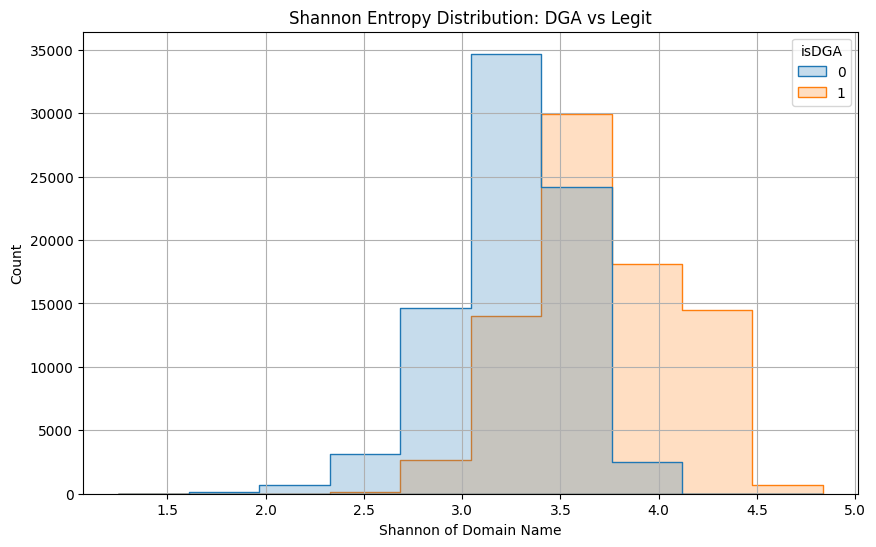

In [39]:
df["shannon_entropy"] = df["domain"].apply(shannon_entropy)
print(df)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="shannon_entropy", hue="isDGA", bins=10, element="step", stat="count", common_norm=False)
plt.title("Shannon Entropy Distribution: DGA vs Legit")
plt.xlabel("Shannon of Domain Name")
plt.ylabel("Count")
plt.grid(True)
plt.show()

### Verdict

As seen, the plots between the shannon entropy of non-DGA and DGA are clearly separated. This indicates that shannon entropy would be a good feature to predict whether a domain is DGA or non-DGA.

## Digits Ratio

Non-DGA domains tend to have low digits ratio while DGA domains generally have higher digits ratio.

In [40]:
def proportion_digits(domain):
  n = len(domain)

  digits = 0
  for c in domain:
    if c.isdigit():
      digits += 1

  return digits / n

        isDGA                          domain  domain_length  shannon_entropy  \
0           1  6xzxsw3sokvg1tc752y1a6p0af.com             30         4.440224   
1           1               glbtlxwwhbnpxs.ru             17         3.616875   
2           1               xxmamopyipbfpk.ru             17         3.572469   
3           1   zfd5szpi18i85wj9uy13l69rg.net             29         4.444188   
4           1                 jpqftymiuver.ru             15         3.640224   
...       ...                             ...            ...              ...   
159995      0                     manhunt.net             11         2.845351   
159996      0                      yupptv.com             10         3.121928   
159997      0                    bbcmundo.com             12         2.918296   
159998      0                   kanogames.com             13         3.238901   
159999      0                    roadrover.cn             12         3.022055   

        digits_ratio  
0   

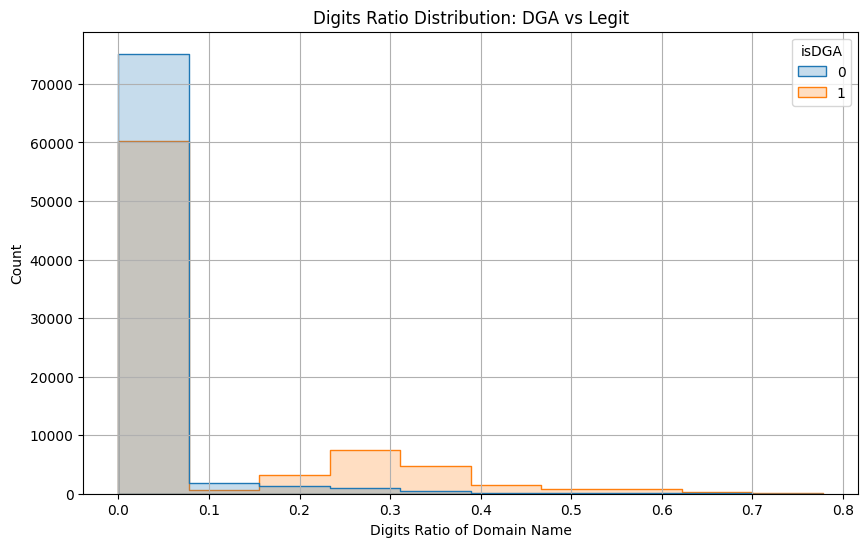

In [41]:
df["digits_ratio"] = df["domain"].apply(proportion_digits)
print(df)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="digits_ratio", hue="isDGA", bins=10, element="step", stat="count", common_norm=False)
plt.title("Digits Ratio Distribution: DGA vs Legit")
plt.xlabel("Digits Ratio of Domain Name")
plt.ylabel("Count")
plt.grid(True)
plt.show()

### Verdict

Contrary to our belief, it seems that many non-DGA and DGA domains have low digit ratio.

However, notice the difference between the graphs beyond the point of ratio = 0.15. Although many non-DGA and DGA overlap at low ratio, digits ratio may still prove to be quite useful in classifying domains.

To prevent our number of features from being too many, we will evaluate other features first.

## Vowel to Consonant Ratio

Since non-DGA domains are based on human language, they tend to have a more balanced and predictable vowel to consonant ratio. Since DGA domains are not constrainted by linguistic rules, these randomly generated strings have a less natural and more skewed vowel to consonant ratio.

In [42]:
def vowel_to_consonant_ratio(domain):
  vowels = 0
  consonants = 0

  for c in domain:
    if c in {'a', 'e', 'i', 'o', 'u'}:
      vowels += 1
    else:
      consonants += 1

  return vowels / consonants

        isDGA                          domain  domain_length  shannon_entropy  \
0           1  6xzxsw3sokvg1tc752y1a6p0af.com             30         4.440224   
1           1               glbtlxwwhbnpxs.ru             17         3.616875   
2           1               xxmamopyipbfpk.ru             17         3.572469   
3           1   zfd5szpi18i85wj9uy13l69rg.net             29         4.444188   
4           1                 jpqftymiuver.ru             15         3.640224   
...       ...                             ...            ...              ...   
159995      0                     manhunt.net             11         2.845351   
159996      0                      yupptv.com             10         3.121928   
159997      0                    bbcmundo.com             12         2.918296   
159998      0                   kanogames.com             13         3.238901   
159999      0                    roadrover.cn             12         3.022055   

        digits_ratio  vc_ra

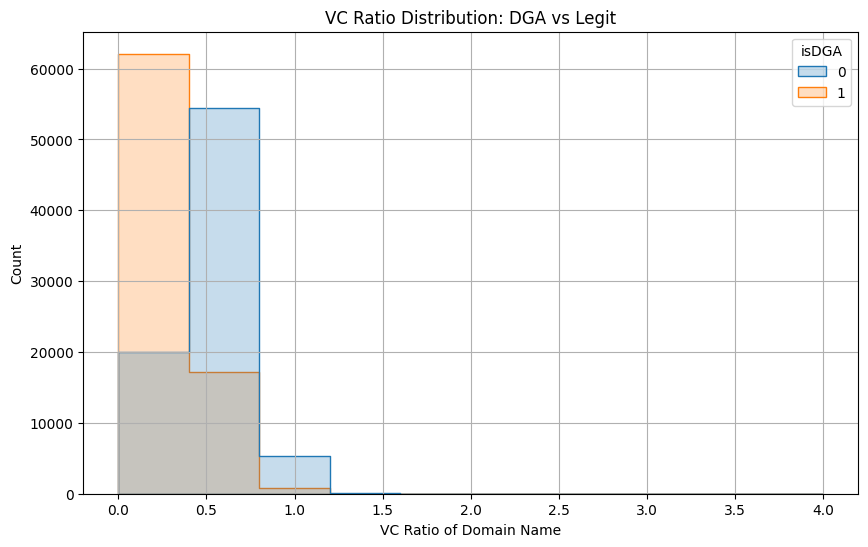

In [43]:
df["vc_ratio"] = df["domain"].apply(vowel_to_consonant_ratio)
print(df)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="vc_ratio", hue="isDGA", bins=10, element="step", stat="count", common_norm=False)
plt.title("VC Ratio Distribution: DGA vs Legit")
plt.xlabel("VC Ratio of Domain Name")
plt.ylabel("Count")
plt.grid(True)
plt.show()

### Verdict

As seen, the plots between the vowel to consonant ratio of non-DGA and DGA are clearly separated. This indicates that vowel to consonant ratio would be a good feature to predict whether a domain is DGA or non-DGA.

## Digit to Letter Ratio

Extending from the fact that Non-DGA domains tend to have low digits ratio while DGA domains generally have higher digits ratio, digits to letter ratio may be a useful feature.

In [44]:
def digit_to_letter_ratio(domain):
  digit = 0
  letter = 0

  for c in domain:
    if c in {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}:
      digit += 1
    else:
      letter += 1

  return digit / letter

        isDGA                          domain  domain_length  shannon_entropy  \
0           1  6xzxsw3sokvg1tc752y1a6p0af.com             30         4.440224   
1           1               glbtlxwwhbnpxs.ru             17         3.616875   
2           1               xxmamopyipbfpk.ru             17         3.572469   
3           1   zfd5szpi18i85wj9uy13l69rg.net             29         4.444188   
4           1                 jpqftymiuver.ru             15         3.640224   
...       ...                             ...            ...              ...   
159995      0                     manhunt.net             11         2.845351   
159996      0                      yupptv.com             10         3.121928   
159997      0                    bbcmundo.com             12         2.918296   
159998      0                   kanogames.com             13         3.238901   
159999      0                    roadrover.cn             12         3.022055   

        digits_ratio  vc_ra

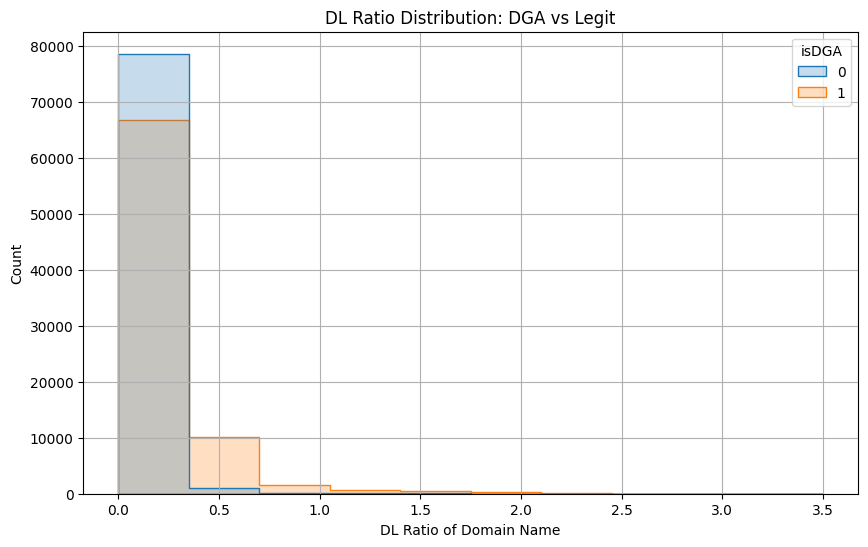

In [45]:
df["dl_ratio"] = df["domain"].apply(digit_to_letter_ratio)
print(df)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="dl_ratio", hue="isDGA", bins=10, element="step", stat="count", common_norm=False)
plt.title("DL Ratio Distribution: DGA vs Legit")
plt.xlabel("DL Ratio of Domain Name")
plt.ylabel("Count")
plt.grid(True)
plt.show()

### Verdict

Despite a logically extension from digits ratio, it seems that the digit to letter ratio of DGA and non-DGA domains are not all that different. Digits to letter ratio may not be a useful feature to include when training our model.

## N-Gram Score

N-gram score is another way of measuring the entropy of a domain name by utilising the fact that domain names abide by the constraints of linguistics.

For example, specific sequences of characters are common in English words, such as "ing", "th" and "tion". These are called n-grams. In our context, "com" will probably be the most common, given that majority of legitimate domains end with .com.

To reinforce the understanding of n-grams, here is a list of all possible 4-grams of the word "Google": ["Goog", "oogl", "ogle"]. The algorithm is sliding window of length n and extracting all possible substrings of length n from the word itself.

Non-DGA domains will have higher n-gram scores while DGA domains will have lower n-gram scores.

### Calculating N-Gram Score

1. Obtain a large database of legitimate domain names (or common English words)
2. From this database, extract all possible n-grams
3. Count the frequency of all possible n-grams
4. This gives a statistical model of common n-grams that would appear in legitimate domains
5. For each domain to be classified, extract its n-grams
6. For each n-gram in this domain, look up the frequency that it has appeared in the statistical model and add its frequency to the n-gram score

In our context, I have done the following:

1. This large database (of 1 million most queried legitimate domains) is obtained from [Cisco Umbrella](https://s3-us-west-1.amazonaws.com/umbrella-static/index.html)
2. I will be extracting 3-grams, 4-grams and 5-grams. This is to include both lower-order and higher-order n-grams to cover a wider basis.
3. Luckily, scikit-learn has an in-built function to allow us to perform calculating of n-gram scores. For more information, see [here](https://s3-us-west-1.amazonaws.com/umbrella-static/index.html).

In [46]:
top1m = pd.read_csv("umbrella-top-1m.csv", header=None)

top1m.drop(top1m.columns[0], axis=1, inplace=True)
top1m.columns = ["domain"]

print(top1m)

                    domain
0               google.com
1            microsoft.com
2           www.google.com
3       data.microsoft.com
4             facebook.com
...                    ...
999995     x9.wgkuntku.com
999996     x9.wiuuynsb.com
999997     x9.wiyufcdu.com
999998     x9.wjpqipsm.net
999999     x9.wkjdszqo.com

[1000000 rows x 1 columns]


In [47]:
# this initializes a CountVectorizer object
# a CountVectorizer is a tool to convert a collection of text into a matrix of token counts
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 5), lowercase=True, preprocessor=lambda x: "".join(c for c in x.lower() if c.isalnum()))
# analyzer="char" tells the vectorizer to analyze the input at character level instead of word level
# ngram_range specifies the range of n-grams to consider (here, we extract all 3-grams, 4-grams and 5-grams)
# lowercase=True converts all out input domains into lowercase
# preprocesser is a function that is applied to all input domains before n-gram extraction (here, we remove non-alphanumeric characters)

# this feeds our legitimate database of domains into the CountVectorizer object for n-gram extraction
sparse_matrix = vectorizer.fit_transform(top1m["domain"])
# a sparse matrix of shape (domains, n-grams)
# each row = a domain, each column = a unique n-gram
# cell (i, j) = how many times that n-gram j appears in domain i

# sparse_matrix.sum(axis=0) sums the sparse_matrix along columns, resulting in row vector
  # results in a new sparse matrix into shape (1, n-grams)
  # each element represents the total count the corresponding unique n-gram appears across all domains
# .getA1() converts the above into a 1D NumPy array
log10_count = np.log10(sparse_matrix.sum(axis=0).getA1())
# a NumPy array of length n-grams
  # essentially, .getA1() removes the corresponding unique n-gram
# each element = log10 of the total count the corresponding unique n-gram appears across all domains

# retrieves the corresponding unique n-grams that were removed
# the order corresponds to that in log10_count
ngrams_list = vectorizer.get_feature_names_out()

import operator
_sorted_ngrams = sorted(zip(ngrams_list, log10_count), key=operator.itemgetter(1), reverse=True)
print("Total Number of N-Grams Found: %d" % len(_sorted_ngrams))

print("Top 10 Most Common N-Grams")
for ngram, count in _sorted_ngrams[:10]:
    print(ngram, count)

Total Number of N-Grams Found: 2670768
Top 10 Most Common N-Grams
com 5.796899585366823
net 5.221351632323721
sco 4.944230905795175
scom 4.883479731481953
eco 4.872930899174456
ecom 4.831652252770059
www 4.825393658073358
cdn 4.76445261744024
tco 4.710396646013606
oco 4.704802327472533


        isDGA                          domain  domain_length  shannon_entropy  \
0           1  6xzxsw3sokvg1tc752y1a6p0af.com             30         4.440224   
1           1               glbtlxwwhbnpxs.ru             17         3.616875   
2           1               xxmamopyipbfpk.ru             17         3.572469   
3           1   zfd5szpi18i85wj9uy13l69rg.net             29         4.444188   
4           1                 jpqftymiuver.ru             15         3.640224   
...       ...                             ...            ...              ...   
159995      0                     manhunt.net             11         2.845351   
159996      0                      yupptv.com             10         3.121928   
159997      0                    bbcmundo.com             12         2.918296   
159998      0                   kanogames.com             13         3.238901   
159999      0                    roadrover.cn             12         3.022055   

        digits_ratio  vc_ra

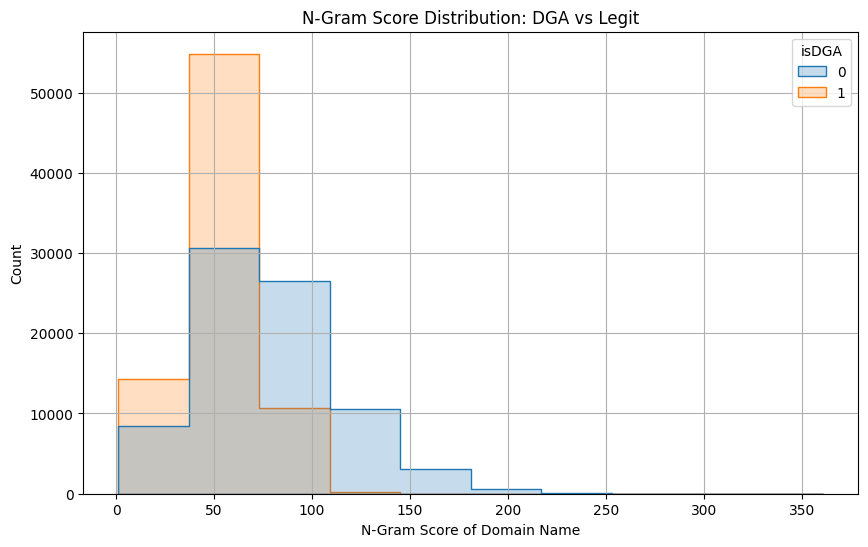

In [48]:
# vectorizer.transform()
  # uses the already fitted CountVectorizer to extract all the possible n-grams from df["domain"]
  # then, maps it against the unique n-grams found in our legitimate database
  # similarly, results in a sparse matrix of shape (number of domains, number of n-grams in legitimate database)
    # each row = a domain in df["domain"], each column = a unique n-gram learned from the legitimate database
    # cell (i, j) = how many times that n-gram j appears in domain i
# log10_count = (1, n-grams) and vectorizer.transform(df["domain"]) = (domains, n-grams)
df["ngram_score"]= log10_count * vectorizer.transform(df["domain"]).T
# the result is a (1, domains) where each value = summation of log10_count(i) * count(i, j)
  # log10_count(i) = log10 frequency of n-gram i in the legitimate database
  # count(i, j) = number of times n-gram i appears in domain j in df["domain"]
print(df)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="ngram_score", hue="isDGA", bins=10, element="step", stat="count", common_norm=False)
plt.title("N-Gram Score Distribution: DGA vs Legit")
plt.xlabel("N-Gram Score of Domain Name")
plt.ylabel("Count")
plt.grid(True)
plt.show()

### Verdict

As seen, the plots between the n-gram score of non-DGA and DGA are clearly separated. This indicates that n-gram score would be a good feature to predict whether a domain is DGA or non-DGA.

## Tokenising

Again, tokenising is another way to measure the randomness of a domain name. This is done by assigning each character an integer and converting a domain name into a list of integers. Non-DGA domains will have common occurrences sequences of numbers while DGA domains will have more random occurrences of sequences of numbers.

Note that since each domain may have different lengths, padding this field is necessary and will be done in the subsequent steps.

In [49]:
tokens = {}
for i in range(1, 1 + 10):
  tokens[chr(i - 1 + ord('0'))] = i;

for i in range(11, 11 + 26, 1):
  tokens[chr(i - 11 + ord('a'))] = i

tokens["PAD"] = 0
tokens['.'] = 37

def tokenize(domain):
  encoded = []

  for c in domain:
    if c in tokens:
      encoded.append(tokens[c])

  return encoded

df["tokenize"] = df["domain"].apply(tokenize)
print(df)

        isDGA                          domain  domain_length  shannon_entropy  \
0           1  6xzxsw3sokvg1tc752y1a6p0af.com             30         4.440224   
1           1               glbtlxwwhbnpxs.ru             17         3.616875   
2           1               xxmamopyipbfpk.ru             17         3.572469   
3           1   zfd5szpi18i85wj9uy13l69rg.net             29         4.444188   
4           1                 jpqftymiuver.ru             15         3.640224   
...       ...                             ...            ...              ...   
159995      0                     manhunt.net             11         2.845351   
159996      0                      yupptv.com             10         3.121928   
159997      0                    bbcmundo.com             12         2.918296   
159998      0                   kanogames.com             13         3.238901   
159999      0                    roadrover.cn             12         3.022055   

        digits_ratio  vc_ra

## Maximum Consecutive Consonants

Again, since non-DGA domains abide by the rules of linguistics, they generally will not have long consecutive substrings of consonants. DGAs will generally have longer consecutive substrings of consonants since they are generated randomly and there exists more consonants than vowels in the alphabet.

In [50]:
def max_consecutive_consonant(domain):
  mx = 0

  i = 0
  while i < len(domain):
    while i < len(domain) and domain[i] in {'a', 'e', 'i', 'o', 'u'}:
      i += 1

    j = i + 1
    while j < len(domain) and domain[j] not in {'a', 'e', 'i', 'o', 'u'}:
      j += 1

    mx = max(mx, j - i)
    i = j

  return mx

        isDGA                          domain  domain_length  shannon_entropy  \
0           1  6xzxsw3sokvg1tc752y1a6p0af.com             30         4.440224   
1           1               glbtlxwwhbnpxs.ru             17         3.616875   
2           1               xxmamopyipbfpk.ru             17         3.572469   
3           1   zfd5szpi18i85wj9uy13l69rg.net             29         4.444188   
4           1                 jpqftymiuver.ru             15         3.640224   
...       ...                             ...            ...              ...   
159995      0                     manhunt.net             11         2.845351   
159996      0                      yupptv.com             10         3.121928   
159997      0                    bbcmundo.com             12         2.918296   
159998      0                   kanogames.com             13         3.238901   
159999      0                    roadrover.cn             12         3.022055   

        digits_ratio  vc_ra

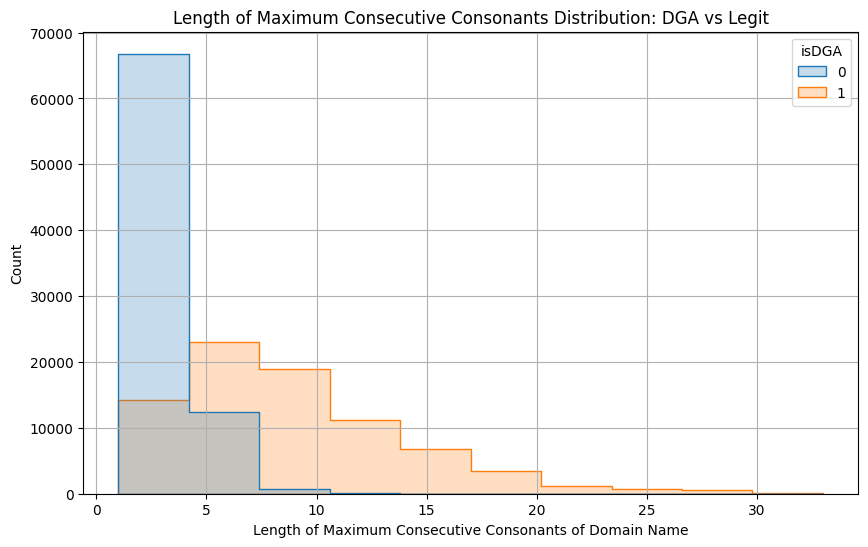

In [51]:
df["mcc"] = df["domain"].apply(max_consecutive_consonant)
print(df)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="mcc", hue="isDGA", bins=10, element="step", stat="count", common_norm=False)
plt.title("Length of Maximum Consecutive Consonants Distribution: DGA vs Legit")
plt.xlabel("Length of Maximum Consecutive Consonants of Domain Name")
plt.ylabel("Count")
plt.grid(True)
plt.show()

### Verdict

As seen, the plots between the length of the maximum consecutive consonant substring of non-DGA and DGA are clearly separated. This indicates that it would be a good feature to predict whether a domain is DGA or non-DGA.

## Number of Unique Characters

Since they are generated randomly, DGAs might use a wider (or narrower) set of characters than typical domains.

In [52]:
def unique_characters(domain):
  st = set()

  for c in domain:
    st.add(c)

  return len(st)

        isDGA                          domain  domain_length  shannon_entropy  \
0           1  6xzxsw3sokvg1tc752y1a6p0af.com             30         4.440224   
1           1               glbtlxwwhbnpxs.ru             17         3.616875   
2           1               xxmamopyipbfpk.ru             17         3.572469   
3           1   zfd5szpi18i85wj9uy13l69rg.net             29         4.444188   
4           1                 jpqftymiuver.ru             15         3.640224   
...       ...                             ...            ...              ...   
159995      0                     manhunt.net             11         2.845351   
159996      0                      yupptv.com             10         3.121928   
159997      0                    bbcmundo.com             12         2.918296   
159998      0                   kanogames.com             13         3.238901   
159999      0                    roadrover.cn             12         3.022055   

        digits_ratio  vc_ra

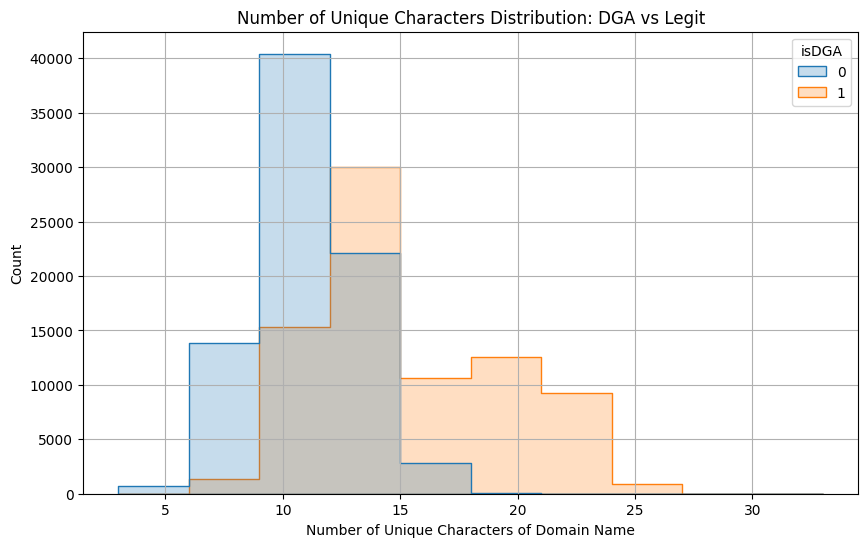

In [53]:
df["unique_chars"] = df["domain"].apply(unique_characters)
print(df)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="unique_chars", hue="isDGA", bins=10, element="step", stat="count", common_norm=False)
plt.title("Number of Unique Characters Distribution: DGA vs Legit")
plt.xlabel("Number of Unique Characters of Domain Name")
plt.ylabel("Count")
plt.grid(True)
plt.show()

### Verdict

As seen, the plots between the number of unique characters of non-DGA and DGA are clearly separated. This indicates that it would be a good feature to predict whether a domain is DGA or non-DGA.

## Selecting Features

From the graphs, the following features will be used to train the model:
1. Domain Length
2. Shannon Entropy
3. Vowel to Consonant Ratio
4. N-Gram Score
5. Tokenising
6. Maximum Consecutive Consonants
7. Number of Unique Characters

In [54]:
df = df.drop(columns=["dl_ratio", "digits_ratio"])
print(df)

        isDGA                          domain  domain_length  shannon_entropy  \
0           1  6xzxsw3sokvg1tc752y1a6p0af.com             30         4.440224   
1           1               glbtlxwwhbnpxs.ru             17         3.616875   
2           1               xxmamopyipbfpk.ru             17         3.572469   
3           1   zfd5szpi18i85wj9uy13l69rg.net             29         4.444188   
4           1                 jpqftymiuver.ru             15         3.640224   
...       ...                             ...            ...              ...   
159995      0                     manhunt.net             11         2.845351   
159996      0                      yupptv.com             10         3.121928   
159997      0                    bbcmundo.com             12         2.918296   
159998      0                   kanogames.com             13         3.238901   
159999      0                    roadrover.cn             12         3.022055   

        vc_ratio  ngram_sco

# Splitting Data

In [55]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

train_dga_count = train_data[train_data["isDGA"] == 1].shape[0]
train_legit_count = train_data[train_data["isDGA"] == 0].shape[0]
test_dga_count = test_data[test_data["isDGA"] == 1].shape[0]
test_legit_count = test_data[test_data["isDGA"] == 0].shape[0]

print(f"Number of DGA in training set: {train_dga_count}")
print(f"Number of non-DGA in training set: {train_legit_count}")
print(f"Number of DGA in test set: {test_dga_count}")
print(f"Number of non-DGA in test set: {test_legit_count}")

Number of DGA in training set: 64126
Number of non-DGA in training set: 63874
Number of DGA in test set: 15874
Number of non-DGA in test set: 16126


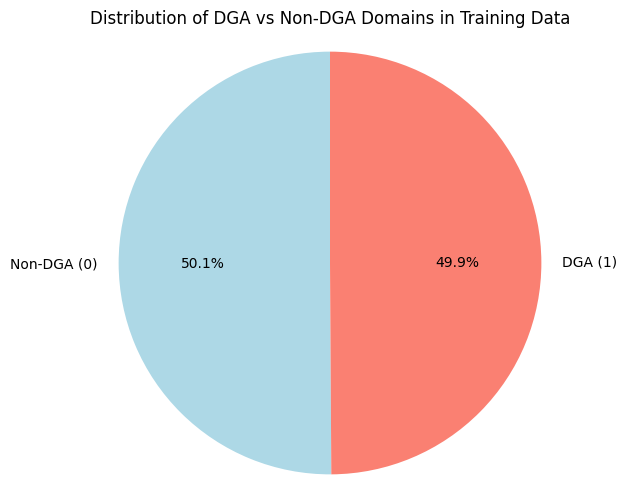

In [56]:
counts = train_data["isDGA"].value_counts()
labels = ["Non-DGA (0)", "DGA (1)"]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=["lightblue", "salmon"])
plt.title("Distribution of DGA vs Non-DGA Domains in Training Data")
plt.axis("equal")
plt.show()

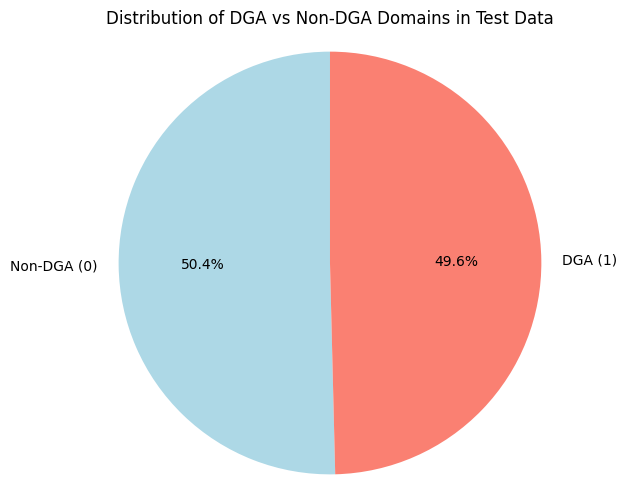

In [57]:
counts = test_data["isDGA"].value_counts()
labels = ["Non-DGA (0)", "DGA (1)"]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=["lightblue", "salmon"])
plt.title("Distribution of DGA vs Non-DGA Domains in Test Data")
plt.axis("equal")
plt.show()

In [58]:
class DGADataset(torch.utils.data.Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    domain_tokens = torch.tensor(row["tokenize"], dtype=torch.long)
    features = torch.tensor([
      row["domain_length"],
      row["shannon_entropy"],
      row["vc_ratio"],
      row["ngram_score"],
      row["mcc"],
      row["unique_chars"]
    ], dtype=torch.float32)
    label = torch.tensor(row["isDGA"], dtype=torch.long)

    return domain_tokens, features, label

def collate_fn(batch):
    domain_tokens_list, features_list, labels_list = zip(*batch)

    padded_tokens = torch.nn.utils.rnn.pad_sequence(domain_tokens_list, batch_first=True, padding_value=0)

    features = torch.stack(features_list)
    labels = torch.stack(labels_list)

    return padded_tokens, features, labels

In [59]:
train_dataset = DGADataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, collate_fn=collate_fn, num_workers=2)

test_dataset = DGADataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, collate_fn=collate_fn, num_workers=2)

for padded_tokens, features, labels in train_loader:
  print(padded_tokens.shape)
  print(features.shape)
  print(labels.shape)
  break

torch.Size([512, 36])
torch.Size([512, 6])
torch.Size([512])


# Creating Model

After much research, I have decided to go with Gated Recurrent Unit (GRU) which is a type of RNN used to process sequential data. It processes sequences of data, one step at a time, and remembers useful information using special gates.

The following image will depict the GRU architecture before we delve into the pros and cons of other model architectures.


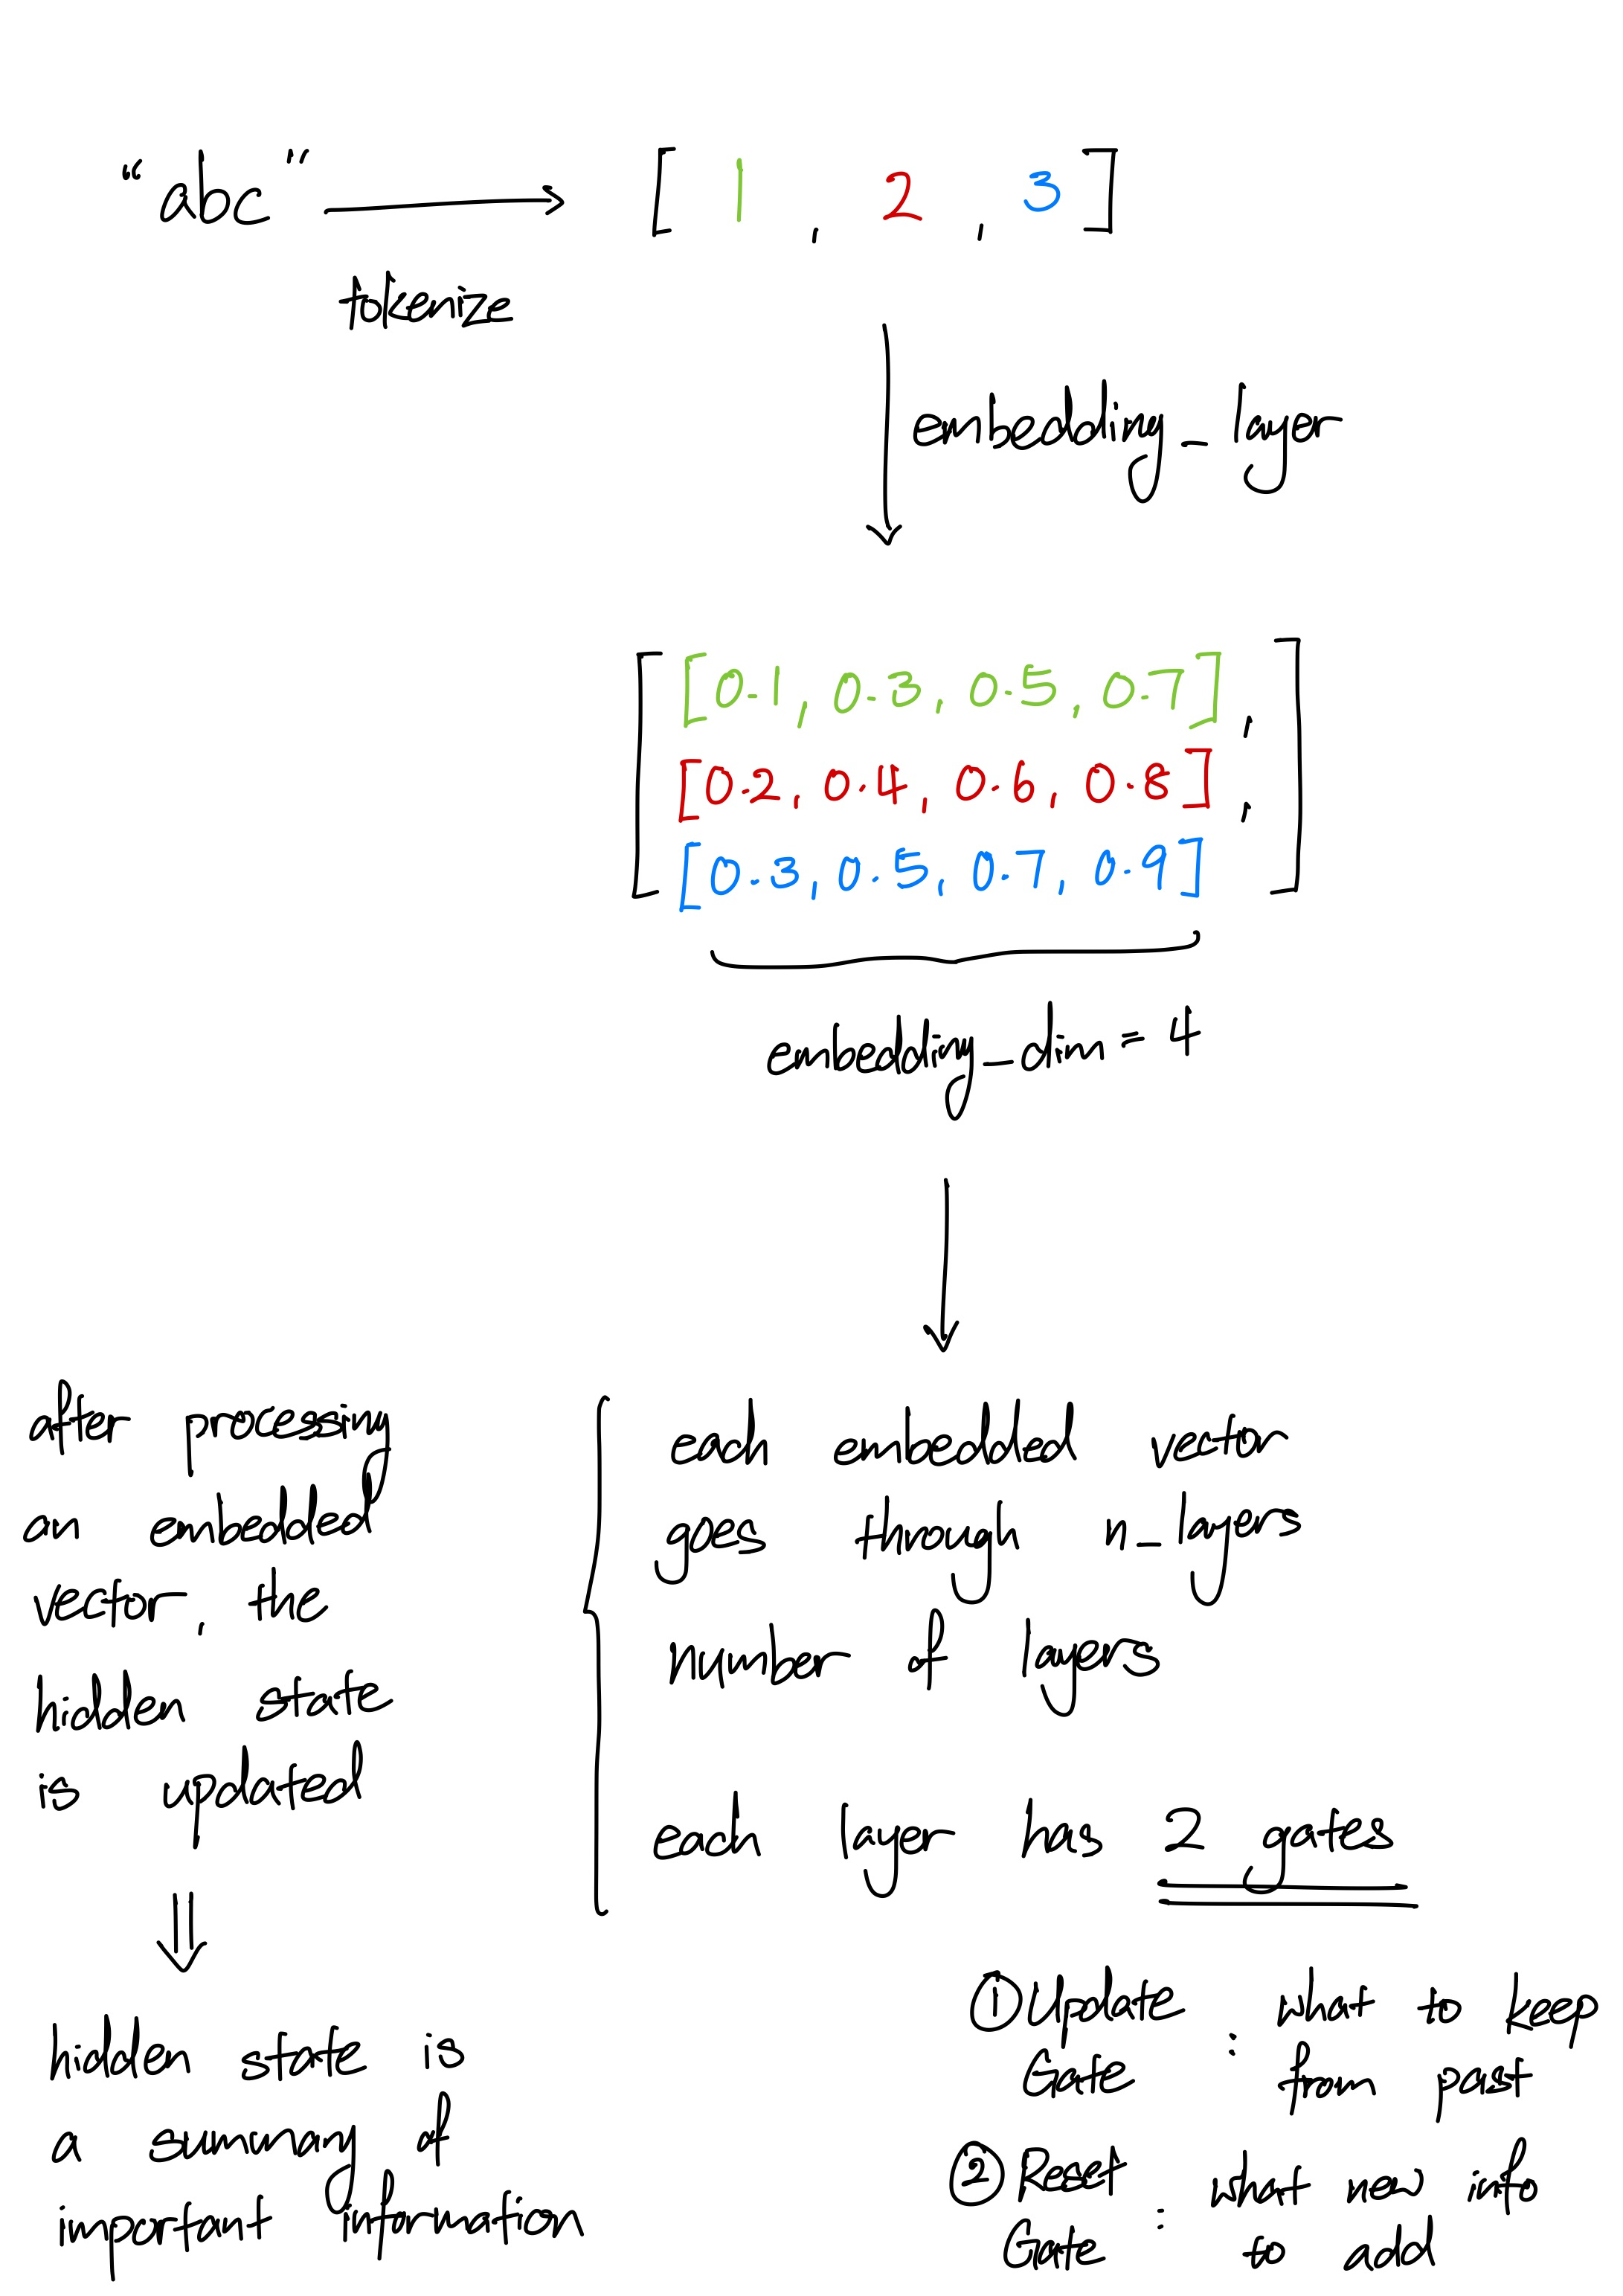

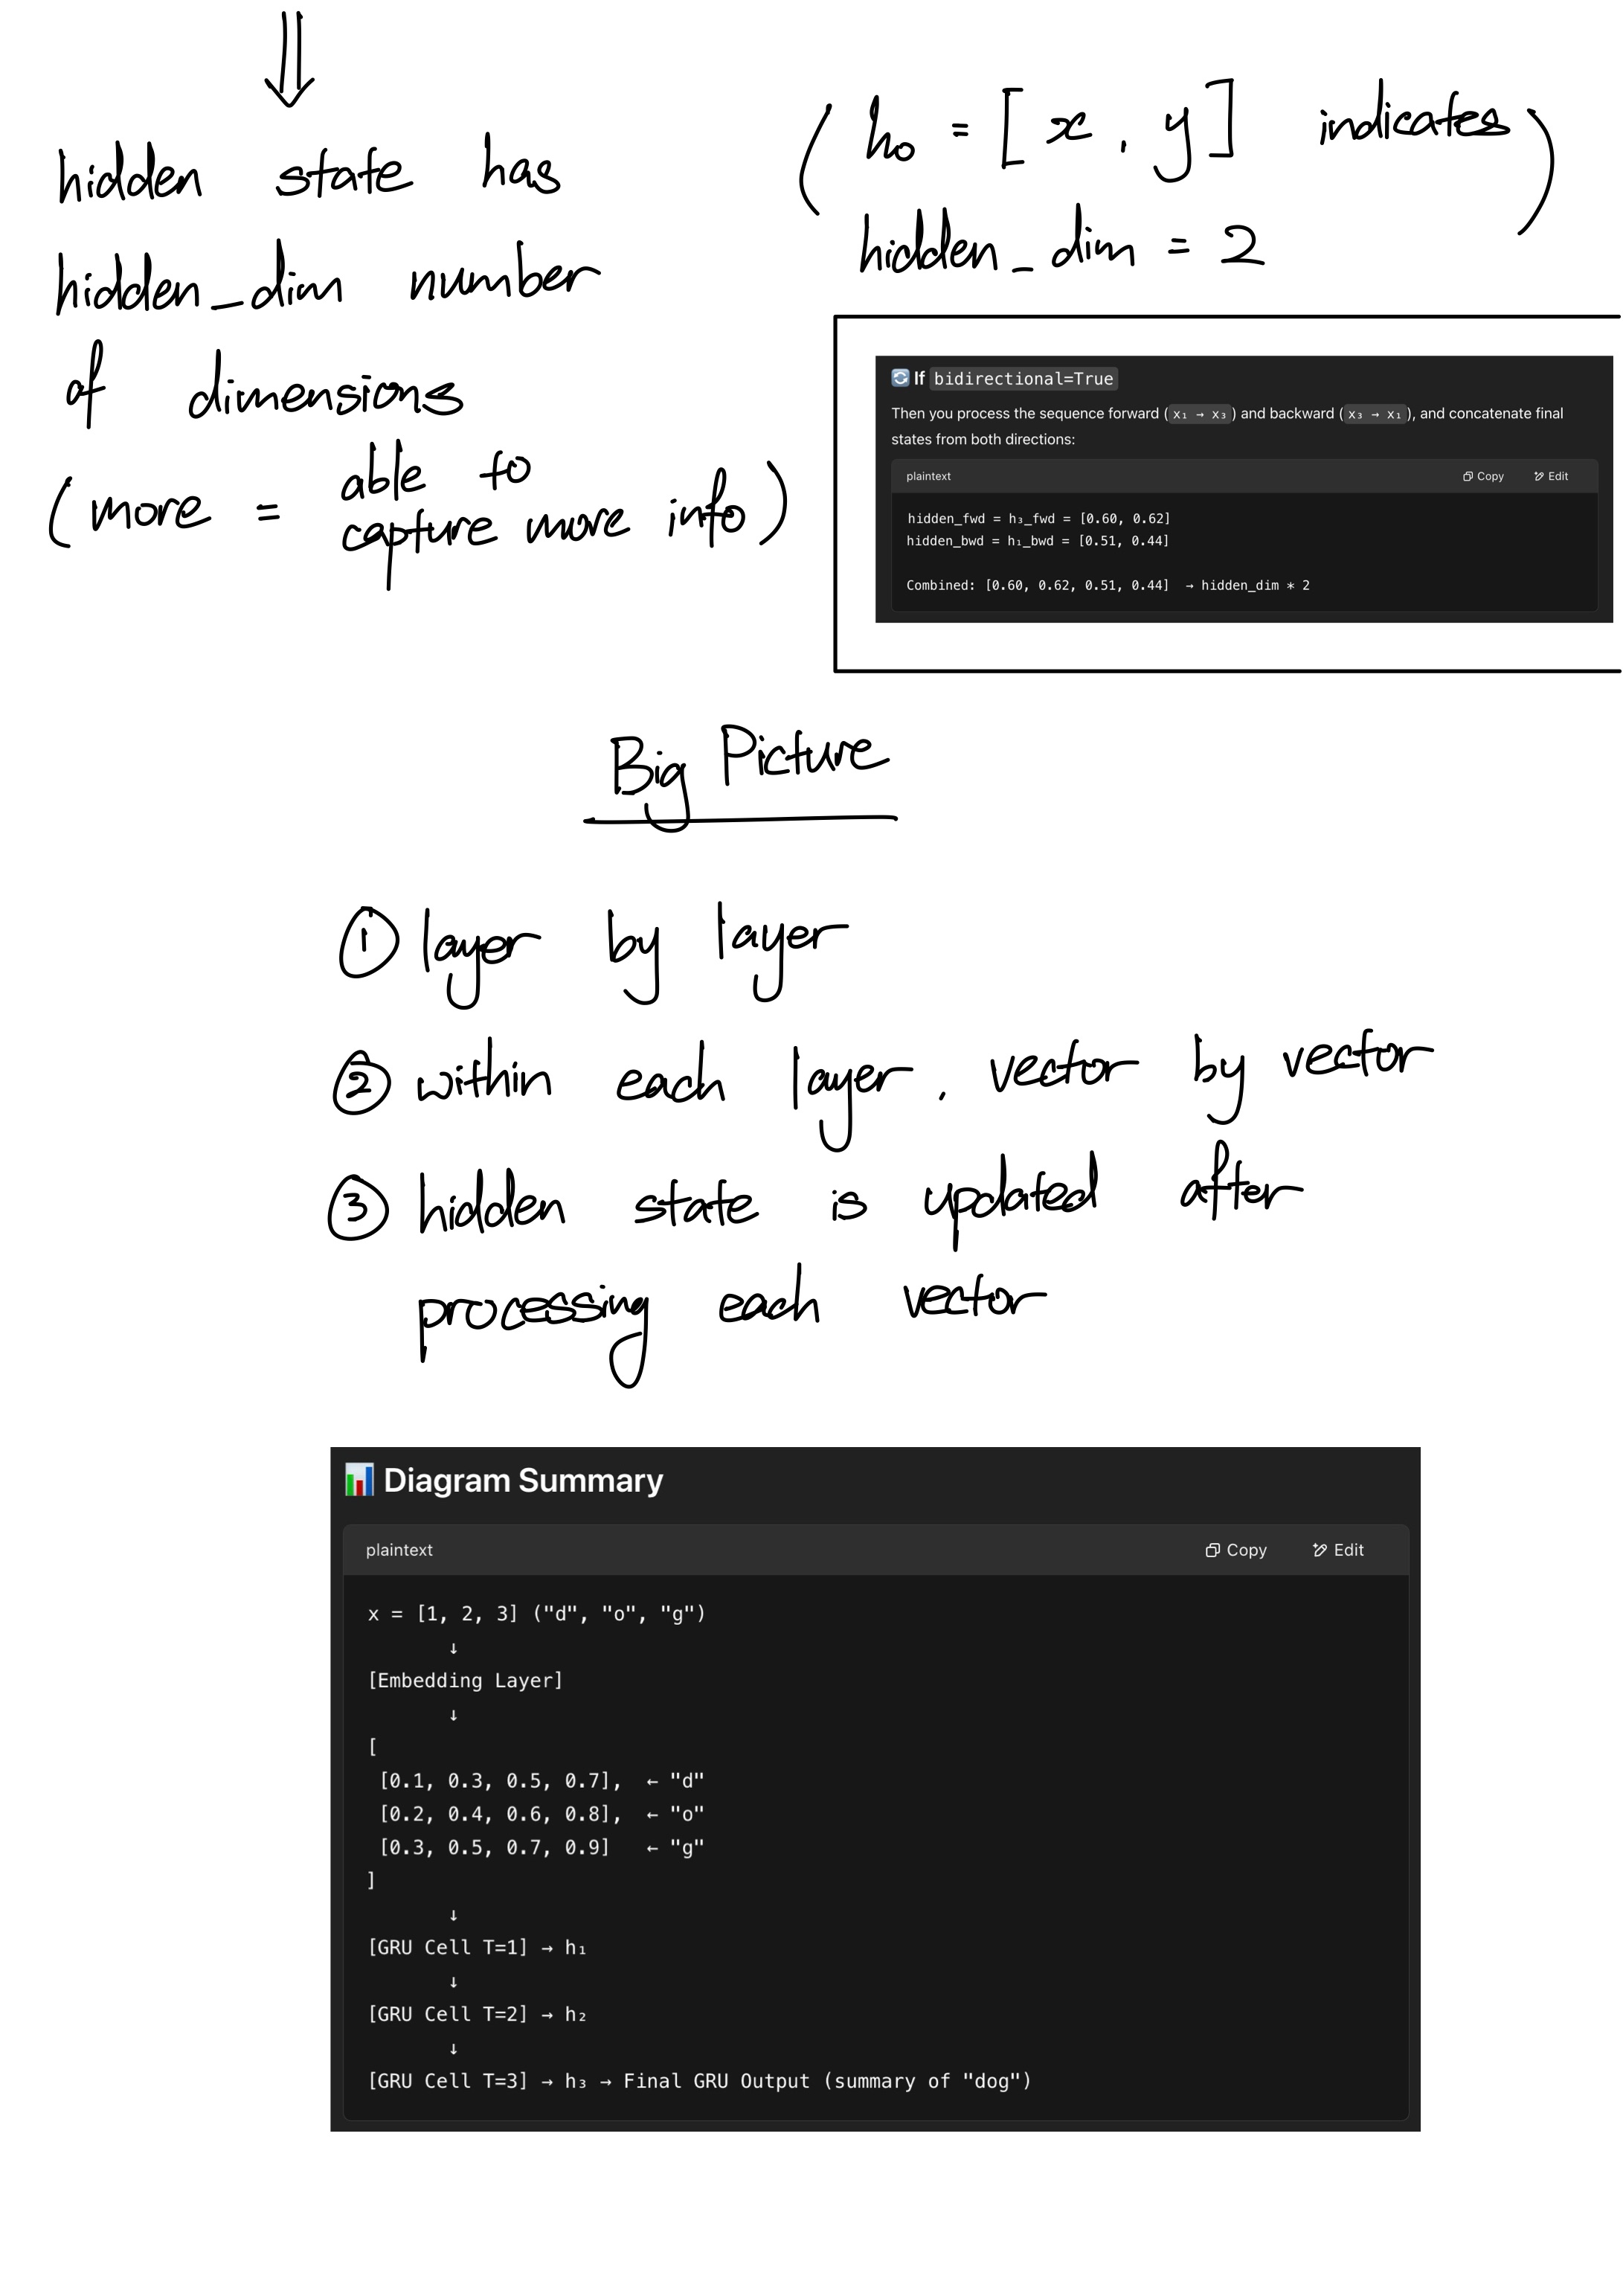

## Alternative Models

1. Classical Machine Learning
2. Text-CNN
3. RNN
4. Transformers

### Classical Machine Learning
#### Pros
1. Fast to train
2. Easier to code

#### Cons
1. Cannot self-learn (limited ability to discover abstract patterns)
2. Heavy emphasis on feature engineering
3. Not inherently designed for sequential data
4. Cannot maintain long-term dependencies

### Text-CNN
#### Pros
1. Decently fast to train

#### Cons
1. Not inherently designed for sequential data (only captures local patterns)
2. Cannot maintain long-term dependencies

### RNN
#### Pros
1. Specifically designed to process sequential data

#### Cons
1. Slower training due to sequential processing
2. Cannot maintain long-term dependencies

### Transformers
#### Pros
1. Best for long-term dependencies

#### Cons
1. NLP focused (mainly used for LLMs / conversational AIs)
2. Not all information can be sieved from the domain name (we have handcrafted features that are numerical)
3. Overkill for DGA resulting in unnecessarily long training time and resource

### LSTM
### Pros
1. Good for long-term dependencies
2. GRU is a simplified version of LSTM

### Cons
1. Longer training time and more computational resource compared to GRU

### GRU

Traditional RNN have trouble remembering long-term patterns and avoiding vanishing gradients.

GRUs solves these issues with gates that help decide:
1. what to keep from the past
2. what to forget
3. what new info to update

Each GRU cell updates a hidden state that summarises what has been seen so far. It uses 2 gates:
1. Update Gate: what to keep from the past
2. Reset Gate: what to forget from the past

These gates are learnt automatically during training.

Since GRU is a type of RNN, it is designed specifically for sequential data. Moreover, it is the middle ground between traditional RNN and LSTM, providing a good balance between the pros and cons of both architectures.

## GRU Model

1. Embed tokenized input
2. Feed embedded sequence into GRU
3. Concatenate GRU output with handcrafted features
4. Feed into sequential layer

In [ ]:
class GRU(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout_rate, num_features):
    # vocab_size = number of unique tokens
    # embedding_dim = size of vector each token maps to
    # hidden_dim = number of units in the GRU hidden state
    # output_dim = number of output classes
    # n_layers = number of stacked GRU layers (each layer has 2 gates)
    # bidrectional = if True, runs GRU forward and backward over the sequence
    # num_features = number of handcrafted features for concatenation later

    super(GRU, self).__init__()
    self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)

    self.gru = nn.GRU(
      embedding_dim,
      hidden_dim,
      num_layers=n_layers,
      bidirectional=True,
      dropout=dropout_rate,
      batch_first=True
    )

    self.dropout = nn.Dropout(dropout_rate)

    self.sequential_layer = nn.Sequential(
      nn.Linear(hidden_dim * 2 + num_features, 256),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      nn.Linear(128, 2)
    )

  def forward(self, tokenised_feature, handcrafted_features):
    embedded = self.dropout(self.embedding_layer(tokenised_feature)) # [batch, seq_len, embedding_dim]
    _, hidden = self.gru(embedded) # hidden: [n_layers * 2, batch, hidden_dim]
    final_hidden_features = torch.cat((hidden[-2], hidden[-1]), dim=1) # [batch, hidden_dim * 2]
    combined = torch.cat((final_hidden_features, handcrafted_features), dim=1) # [batch, hidden_dim * 2 + num_features]

    return self.sequential_layer(combined) # [batch, output_dim]

### Model training

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hyperparameters
embedding_dim = 128
hidden_dim = 256
n_layers = 2
dropout_rate = 0.5
num_features = 6

gru_model = GRU(vocab_size=len(tokens), embedding_dim=embedding_dim, hidden_dim=hidden_dim, n_layers=n_layers, dropout_rate=dropout_rate, num_features=num_features)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

In [62]:
gru_model = gru_model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
  gru_model.train()
  total_loss = 0

  for padded_tokens, features, labels in train_loader:
    padded_tokens = padded_tokens.to(device)
    features = features.to(device)
    labels = labels.to(device).long()

    optimizer.zero_grad()
    output = gru_model(padded_tokens, features)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch: {epoch}, Loss: {total_loss}")

Epoch: 0, Loss: 28.097092781215906
Epoch: 1, Loss: 12.216172482818365
Epoch: 2, Loss: 7.407156941480935
Epoch: 3, Loss: 5.388350960798562
Epoch: 4, Loss: 4.076923485496081
Epoch: 5, Loss: 3.6507390261394903
Epoch: 6, Loss: 2.9754097930854186
Epoch: 7, Loss: 2.740848516463302
Epoch: 8, Loss: 2.339631538139656
Epoch: 9, Loss: 2.226494188478682


### Model Evaluation

31836 32000
Counter({0: 16126, 1: 15874})
Counter({0: 16056, 1: 15944})
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     16126
           1       0.99      1.00      0.99     15874

    accuracy                           0.99     32000
   macro avg       0.99      0.99      0.99     32000
weighted avg       0.99      0.99      0.99     32000



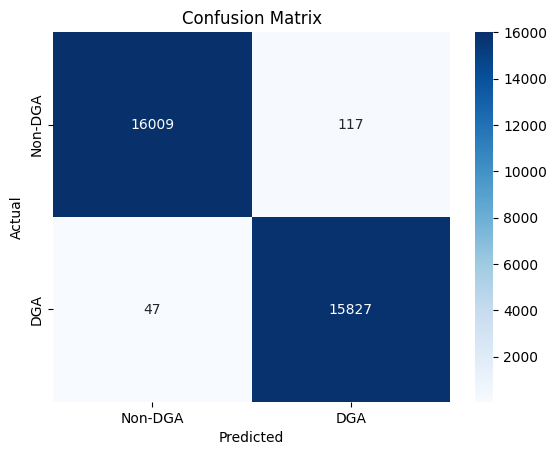

In [63]:
gru_model.eval()

targets = []
preds = []
correct = 0
total = 0

with torch.no_grad():
  correct = 0
  total = 0
  for padded_tokens, features, labels in test_loader:
    padded_tokens = padded_tokens.to(device)
    features = features.to(device)
    labels = labels.to(device).long()

    output = gru_model(padded_tokens, features)
    pred = output.argmax(dim=1)

    targets.extend(labels.tolist())
    preds.extend(pred.tolist())

    correct += (pred == labels).sum().item()
    total += labels.size(0)

print(correct, total)

cnt_targets = Counter(targets)
cnt_preds = Counter(preds)

print(cnt_targets)
print(cnt_preds)

print(classification_report(targets, preds))

cm = confusion_matrix(targets, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-DGA", "DGA"], yticklabels=["Non-DGA", "DGA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

The model achieves basically a 99% in all metrics. When being evaluated on the test set of 32000 unseen domains, it was able to correctly classify 31836 of them.

However, during my optimisations, I was mainly focused on reducing false negatives. These are DGA domains but are classified as non-DGA by my model. Given the importance of security, false negatives are extremely detrimental and should be reduced at all costs.

After many attempts, I was able to reduce the false negative count to 47 out of 32000. There were many other models that had shorter training times and gave more correct predictions but, this was the model that performed the best on reducing false negatives.